# 💳 Task 2 – EDA & Behavioral Risk Exploration  
📘 Version: 2025-07-01

Structured exploratory data analysis (EDA) and risk signal discovery for **Bati Bank’s BNPL Credit Scoring Initiative**. This notebook analyzes behavioral transaction data from an eCommerce platform to uncover patterns in spending frequency, transaction value, platform usage, and product category preferences. Outputs from this task will inform proxy label engineering (Task 4) and model development (Task 5).

---

**Challenge:** B5W5 – Credit Scoring & Risk Modeling  
**Company:** Bati Bank (in partnership with an eCommerce platform)  
**Author:** Nabil Mohamed  
**Branch:** `task-2-exploratory-analysis`  
**Date:** July 2025  

---

### 📌 This notebook covers:
- Importing and profiling raw transactional data (`transactions.csv`)
- Assessing data structure, formats, and null values
- Distribution analysis of transaction value and volume
- Behavioral variation across products, channels, and user segments
- Temporal trend analysis of transaction frequency and monetary value
- Outlier detection and fraud pattern review
- Initial hypotheses for proxy risk label definition and model feature design

In [1]:
# ------------------------------------------------------------------------------
# 🛠 Ensure Notebook Runs from Project Root (for src/ imports to work)
# ------------------------------------------------------------------------------

import os
import sys

# If running from /notebooks/, move up to project root
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("📂 Changed working directory to project root")

# Add project root to sys.path so `src/` modules can be imported
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"✅ Added to sys.path: {project_root}")

# Optional: verify file presence to confirm we're in the right place
expected_path = "data/raw"
print(
    "📁 Output path ready"
    if os.path.exists(expected_path)
    else f"⚠️ Output path not found: {expected_path}"
)

📂 Changed working directory to project root
✅ Added to sys.path: c:\Users\admin\Documents\GIT Repositories\b5w5-credit-scoring-challenge
📁 Output path ready


## 📦 Imports & Environment Setup

This cell loads the core libraries required for behavioral analysis, data profiling, and visualization in the context of credit risk modeling. Imports are grouped by function:

- **Data handling:** `pandas`, `numpy`
- **Visualization:** `matplotlib`, `seaborn`
- **Date/time analysis:** `datetime`, `pandas.to_datetime`
- **System & utilities:** `os`, `warnings`, `pathlib`


In [2]:
# ---------------------------
# 📦 Imports & Environment Setup
# ---------------------------

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date/time analysis
from datetime import datetime
from pandas.api.types import CategoricalDtype

# System & utilities
import os
import warnings
from pathlib import Path

# Configure display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)
warnings.filterwarnings("ignore")

# Set seaborn style
sns.set(style="whitegrid", context="notebook")

## 📥 Load & Preview Raw Transaction Dataset (Task 2 EDA)

This step loads the eCommerce transaction dataset (`data.csv`) containing customer-level purchase behavior used to engineer credit risk features.

- Reads the raw file from `data/raw/data.csv` using the `pandas` library
- Verifies data structure (row/column count, column integrity, data types)
- Outputs diagnostics: shape, column summary, and preview sample
- Raises explicit errors if the file is missing or malformed
- Designed for robustness, reusability, and downstream processing compatibility

This ensures the raw dataset is correctly staged for exploratory analysis and proxy risk label engineering in later tasks.


In [3]:
# ------------------------------------------------------------------------------
# 📦 Load Raw Credit Transaction Data (Production-Grade Loader)
# ------------------------------------------------------------------------------

from src.data_loader import CreditDataLoader  # Custom safe loader for B5W5

# Define path to raw data file (CSV format)
data_path = "data/raw/data.csv"

# Initialize the loader class
loader = CreditDataLoader(filepath=data_path)

# Load DataFrame with defensive error handling
try:
    df = loader.load()
except Exception as e:
    print(f"❌ Failed to load transaction data: {e}")

✅ Transaction dataset loaded: 95,662 rows × 16 columns


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

## 🧾 Layer 1 – Foundational Schema Audit (Structure, Nulls, Uniqueness)

This foundational step validates the structural integrity of the transaction dataset.

- 📏 Logs dataset shape (rows × columns) and column types
- 🔍 Summarizes missing values, constant columns, and high-cardinality fields
- 🧼 Flags uninformative columns (e.g., constant values or overly unique identifiers)
- ⚠️ Highlights potential data quality risks before modeling
- 📊 Returns a diagnostic schema summary dictionary for audit and cleaning

This ensures the data is structurally sound before applying any behavioral or statistical modeling logic.


In [5]:
# ───────────────────────────────────────────────────────────────────────────────
# 🧾 Layer 1 – Foundational Schema Audit (Refactored, Defensive, Styled)
# ───────────────────────────────────────────────────────────────────────────────

# ✅ 1. Import the defensive SchemaAuditor class
from src.eda.schema_auditor import SchemaAuditor

# ✅ 2. Initialize SchemaAuditor with the transactional DataFrame
auditor = SchemaAuditor(df)

# ✅ 3. Generate schema summary and capture results
schema_summary_df = auditor.summarize_schema()

# ✅ 4. Display styled schema summary for notebook review (optional, safe fallback)
try:
    display(auditor.styled_summary())
except Exception:
    print("⚠️ Styled schema display skipped (non-notebook environment detected).")

# ✅ 5. Print concise diagnostics on schema health
auditor.print_diagnostics()

# ✅ 6. Check for duplicate identifiers (adjust column names as needed)
# Ensure correct case: use "CustomerId" not "CustomerID"
auditor.check_duplicate_ids(id_columns=["CustomerId"])

# ✅ 7. Manual schema snapshot for reproducibility (useful in reports or scripting)

print("\n📦 Dataset Overview")
print(f"→ Rows:    {df.shape[0]:,}")
print(f"→ Columns: {df.shape[1]}")

# 🧊 List columns with constant values (no variance)
constant_cols = schema_summary_df[schema_summary_df["is_constant"]].index.tolist()
print("\n🧊 Constant Columns:")
print(constant_cols if constant_cols else "✅ None")

# 📉 List columns with high missingness (>50%)
high_missing_cols = schema_summary_df[
    schema_summary_df["%_missing"] > 50
].index.tolist()
print("\n📉 High-Missing Columns (>50%):")
print(high_missing_cols if high_missing_cols else "✅ None")

# 🔢 Print data types for modeling decisions
print("\n🔢 Data Types by Column:")
for col, dtype in schema_summary_df["dtype"].items():
    print(f"• {col}: {dtype}")

,dtype,n_unique,n_missing,%_missing,is_constant,high_null_flag
TransactionId,object,95662,0,0.00,False,✅ OK
BatchId,object,94809,0,0.00,False,✅ OK
AccountId,object,3633,0,0.00,False,✅ OK
SubscriptionId,object,3627,0,0.00,False,✅ OK
CustomerId,object,3742,0,0.00,False,✅ OK
CurrencyCode,object,1,0,0.00,True,✅ OK
CountryCode,int64,1,0,0.00,True,✅ OK
ProviderId,object,6,0,0.00,False,✅ OK
ProductId,object,23,0,0.00,False,✅ OK
ProductCategory,object,9,0,0.00,False,✅ OK



📝 Schema Diagnostics:
• Constant-value columns:    2
• Columns >20% missing:      0
• Columns >50% missing:      0
• CustomerId: 91,920 duplicates ⚠️ Potential integrity risk.

📦 Dataset Overview
→ Rows:    95,662
→ Columns: 16

🧊 Constant Columns:
['CurrencyCode', 'CountryCode']

📉 High-Missing Columns (>50%):
✅ None

🔢 Data Types by Column:
• TransactionId: object
• BatchId: object
• AccountId: object
• SubscriptionId: object
• CustomerId: object
• CurrencyCode: object
• CountryCode: int64
• ProviderId: object
• ProductId: object
• ProductCategory: object
• ChannelId: object
• Amount: float64
• Value: int64
• TransactionStartTime: object
• PricingStrategy: int64
• FraudResult: int64


## 🔍 Layer 2 – Shared Account Anomaly Detection and Tagging (Enhanced & Defensible)

This layer performs anomaly detection and behavioral tagging of shared accounts within the transactional dataset. Shared accounts—defined as accounts linked to unusually high numbers of `CustomerId`s or multiple `SubscriptionId`s—can distort behavioral signals and undermine the integrity of proxy label creation and feature engineering.

Key business and modeling reasons for this analysis:
- ✅ Identify and tag shared (non-individual) accounts to ensure proxy labels are based on individual customer behaviors
- ✅ Flag potential corporate or misconfigured accounts with unusually high numbers of linked customers or subscriptions
- ✅ Apply defensible statistical methods (IQR) to detect outlier behaviors without arbitrary thresholds

The following diagnostics and outputs are generated:
1. 📊 Per-AccountId statistics: unique `CustomerId`s, unique `SubscriptionId`s, and transaction counts
2. 🚨 Outlier detection on unusually high customer counts (IQR method)
3. 🚨 Flagging of accounts with multiple subscription IDs (direct check)
4. 🏷️ Application of a binary `IsSharedAccount` tag back to the transaction-level DataFrame
5. 📝 Styled summary table of top suspicious accounts for business validation

This step ensures that downstream clustering, feature engineering, and risk modeling are not compromised by noise from group-level or shared accounts, enabling more accurate and interpretable credit risk predictions.


In [6]:
# ───────────────────────────────────────────────────────────────────────────────
# 🔍 Layer 2 – Run Shared Account Anomaly Detection and Tagging (Refactored)
# ───────────────────────────────────────────────────────────────────────────────

# ✅ Step 1: Import the AccountAnomalyDetector class
from src.eda.account_anomaly_detector import AccountAnomalyDetector

# ✅ Step 2: Initialize the detector with the transaction DataFrame
anomaly_detector = AccountAnomalyDetector(df)  # Create instance with input DataFrame

# ✅ Step 3: Compute per-account statistics (unique customers, subscriptions, transactions)
account_stats = (
    anomaly_detector.compute_account_statistics()
)  # Generate summary statistics

# ✅ Step 4: Run anomaly detection to flag shared accounts based on IQR and subscription mismatches
account_stats_with_flags = anomaly_detector.detect_shared_accounts()  # Detect anomalies

# ✅ Step 5: Print concise anomaly detection summary and show top suspicious accounts
anomaly_detector.print_anomaly_summary()  # Display shared account detection summary

# ✅ Step 6: Apply shared account tagging back to the original transaction DataFrame
tagged_df = (
    anomaly_detector.tag_dataframe()
)  # Add IsSharedAccount column to original data

# ✅ Optional: Display updated DataFrame head to verify tagging
display(tagged_df.head())  # Preview the updated DataFrame

🔍 Shared Accounts Detected: 10 of 3,633 total accounts.


,UniqueCustomers,UniqueSubscriptions,TransactionCount,HighCustomerOutlier,MultipleSubscriptions,IsSharedAccount
AccountId,,,,,,
AccountId_4841,2577,2,30893,1,1,1
AccountId_4840,1723,1,1738,1,0,1
AccountId_10,182,1,965,1,0,1
AccountId_4249,56,1,4457,1,0,1
AccountId_1074,20,1,20,1,0,1
AccountId_398,14,1,83,1,0,1
AccountId_2420,11,1,28,1,0,1
AccountId_4713,7,1,7,1,0,1
AccountId_2366,6,1,9,1,0,1


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,IsSharedAccount
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,"1,000.00",1000,2018-11-15T02:18:49Z,2,0,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.00,20,2018-11-15T02:19:08Z,2,0,1
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.00,500,2018-11-15T02:44:21Z,2,0,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,"20,000.00",21800,2018-11-15T03:32:55Z,2,0,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.00,644,2018-11-15T03:34:21Z,2,0,1


## 🔍 Layer 3 – Customer–Account–Subscription Relationship Diagnostics (Enhanced & Defensible with Shared Split & Capping)

This layer performs an enhanced exploratory analysis of the relationships between key identifiers (`CustomerId`, `AccountId`, and `SubscriptionId`) in the transactional dataset. It incorporates optional **shared account splitting** and **percentile-based frequency capping** to improve interpretability and robustness.

### Key Business and Modeling Objectives:
- ✅ Identify the optimal aggregation level for proxy label creation and feature engineering (Customer vs. Account)
- ✅ Detect and visualize structural anomalies (shared accounts, multi-subscription mappings, frequency outliers)
- ✅ Surface behavioral patterns that may indicate credit risk clusters or usage shifts

### Visual Diagnostics and Outputs:
1. 📊 Distribution of **AccountIds per CustomerId**
2. 📊 Distribution of **SubscriptionIds per CustomerId**
3. 📊 Distribution of **SubscriptionIds per AccountId**
4. 🔄 Distribution of **CustomerIds per AccountId** (reverse mapping)
5. 🔢 Distribution of **Transaction Frequency per CustomerId** (with optional capping and shared split)
6. 📝 **Summary Statistics Tables** for both Customer-level and Account-level groupings, styled for readability

These diagnostics inform defensible decisions on segmentation strategy, risk proxy design, and data aggregation layers in the modeling pipeline.


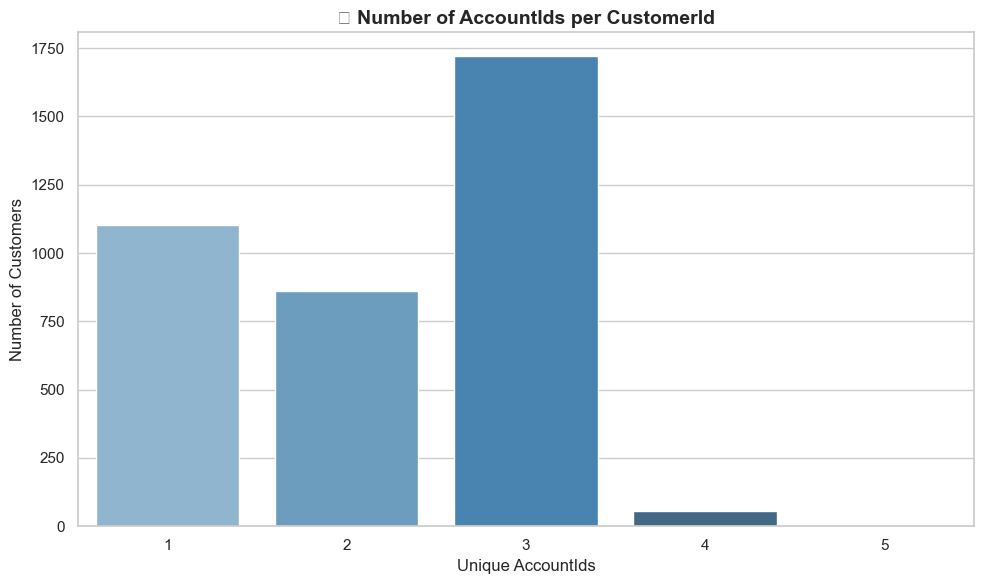

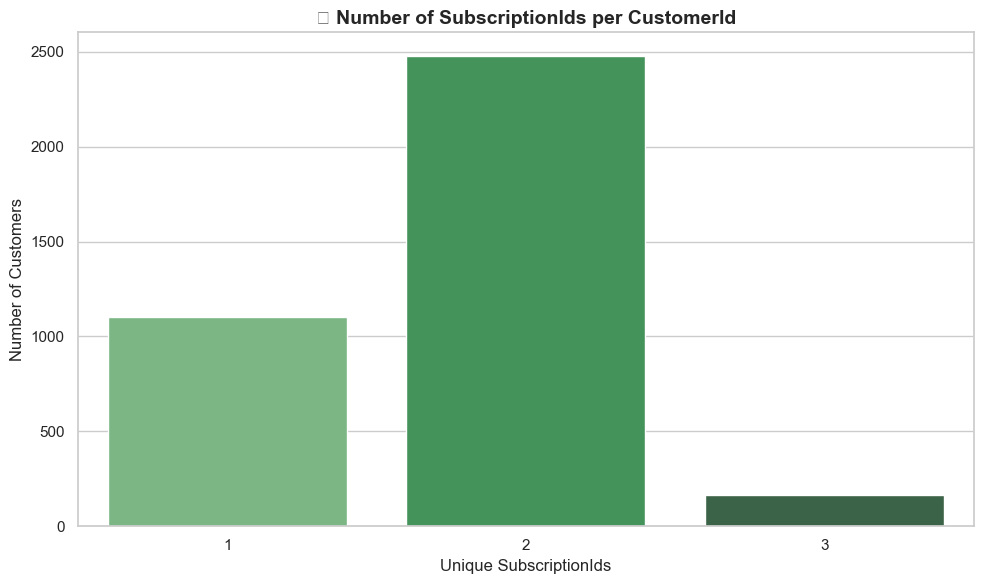

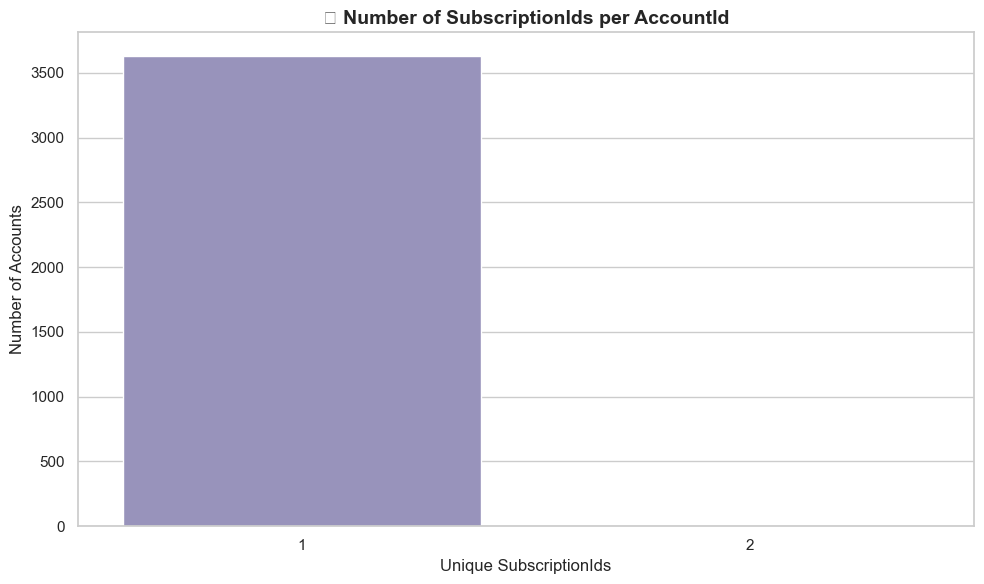

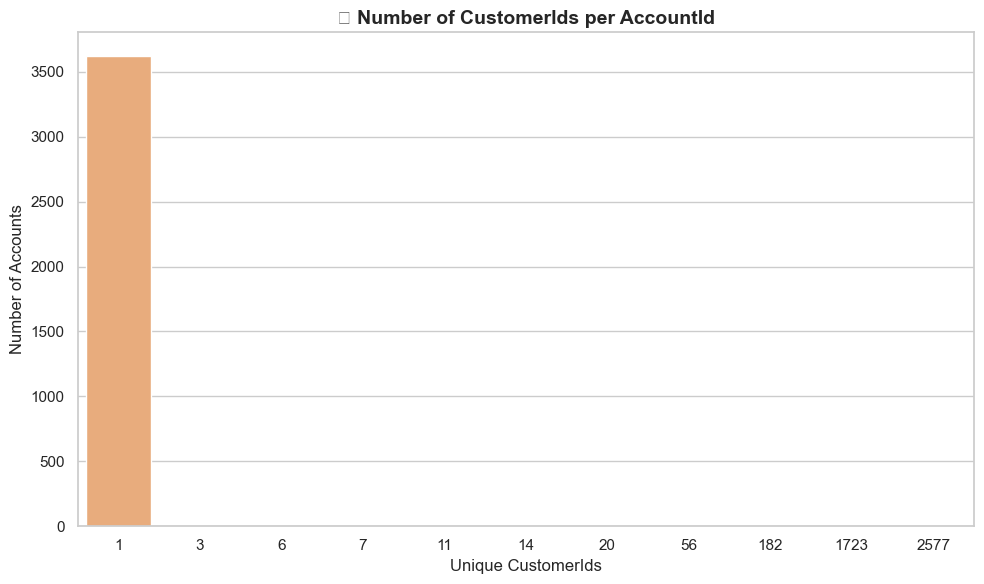

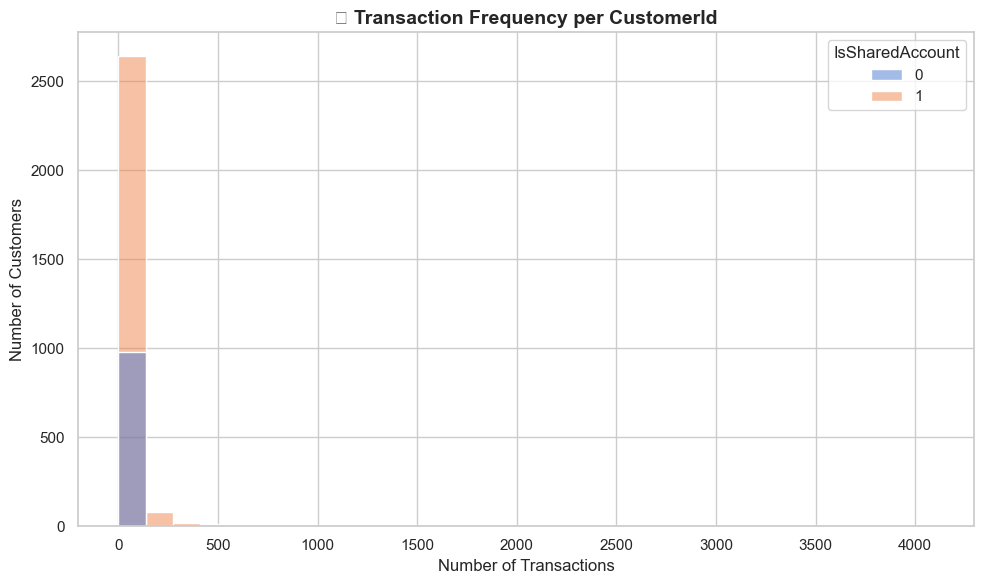

,AccountsPerCustomer,SubscriptionsPerCustomer,TransactionsPerCustomer
NumCustomers,3742.000000,3742.000000,3742.000000
mean,2.200000,1.750000,18.080000
std,0.880000,0.520000,25.770000
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000
50%,2.000000,2.000000,7.000000
75%,3.000000,2.000000,20.000000
max,5.000000,3.000000,98.000000


,CustomersPerAccount,SubscriptionsPerAccount,TransactionsPerAccount
NumAccounts,3633.000000,3633.000000,3633.000000
mean,2.260000,1.000000,26.330000
std,51.500000,0.020000,520.210000
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000
50%,1.000000,1.000000,4.000000
75%,1.000000,1.000000,14.000000
max,2577.000000,2.000000,30893.000000


In [7]:
# ───────────────────────────────────────────────────────────────────────────────
# 🧾 Layer 3 – Run Enhanced Relationship Diagnostics (Final with Shared Split & Capping)
# ───────────────────────────────────────────────────────────────────────────────

# ✅ Import the RelationshipExplorer class
from src.eda.relationship_explorer import RelationshipExplorer

# ✅ Step 1: Initialize RelationshipExplorer with enriched DataFrame (with IsSharedAccount tagging)
relationship_explorer = RelationshipExplorer(tagged_df)

# ✅ Step 2: Generate all diagnostic plots (with shared split and transaction frequency capping at 95%)
relationship_explorer.plot_all_relationships(
    apply_cap=False,  # Use correct argument name
    cap_percentile=0.95,  # Use correct argument name
    hue="IsSharedAccount",  # Use correct argument name
)

# ✅ Step 3: Compute and display customer-level summary statistics (with capping)
relationship_summary = relationship_explorer.compute_summary_stats(
    apply_cap=True,  # Correct argument name
    cap_percentile=0.95,  # Correct argument name
)

# ✅ Step 4: Display styled customer-level table
display(relationship_summary)

# ✅ Step 5: Compute and display account-level summary statistics (no capping needed here)
account_summary = relationship_explorer.compute_account_level_stats()

# ✅ Step 6: Display styled account-level table
display(account_summary)

## 💰 Layer 4 – Monetary Value Distributions (Enhanced with Log Scaling & Dynamic Capping)

This layer analyzes the behavior of key monetary variables (`Amount` and `Value`) to surface distribution patterns, outliers, and segmentation signals critical for defensible feature engineering.

Key exploration elements:
- ✅ **`Amount`**: Signed transaction flow (positive = debit, negative = refund)
- ✅ **`Value`**: Absolute transaction size (positive magnitude)
- ✅ Visualizations include:
  1. 📊 **Histogram + KDE**: To understand skew, variance, and density
  2. 🔍 **Boxplot**: To highlight extreme values and spread
  3. ⚠️ **Optional Log Scale**: For long-tailed or exponential distributions
  4. 🛑 **Optional Percentile Capping (default P95)**: To control the visual impact of extreme outliers without data removal
  5. 🧩 **Optional Shared vs. Individual Account Split**: To surface behavioral divergence across account types

These visual insights support the defensible design of monetary features, proxy thresholds, and model robustness strategies.


📊 Distribution of 'Amount' (Signed Flow) by Shared Account (Log Scaled, No Capping)


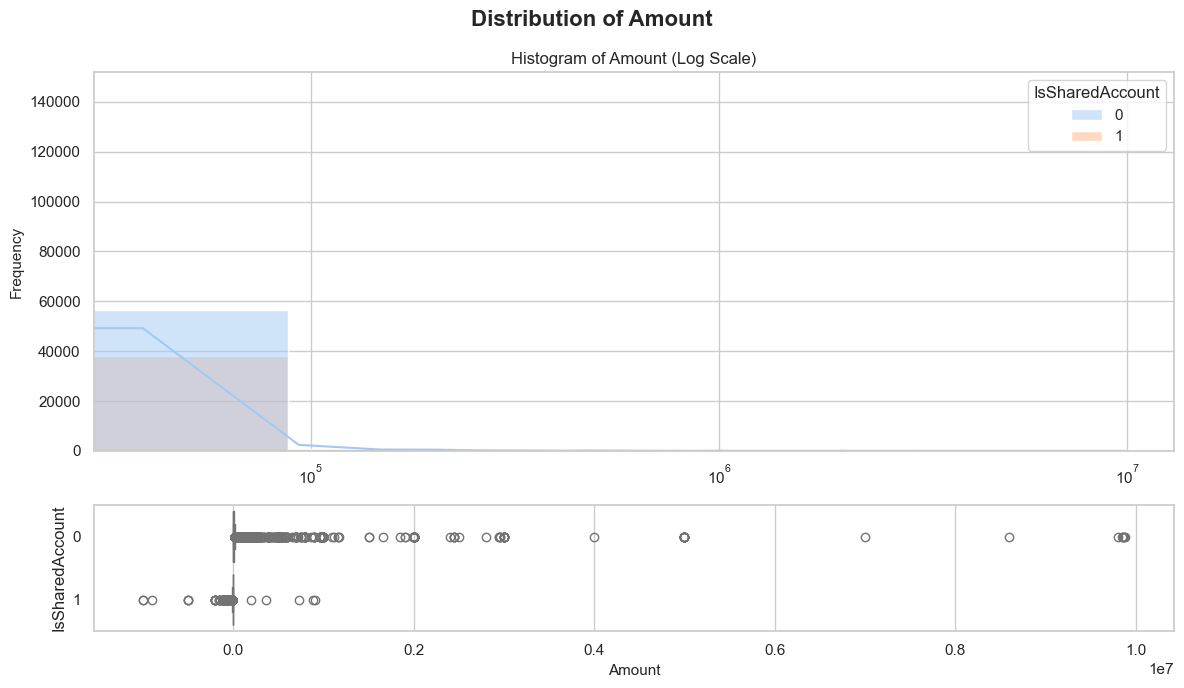

📊 Distribution of 'Value' (Magnitude) by Shared Account (Log Scaled, No Capping)


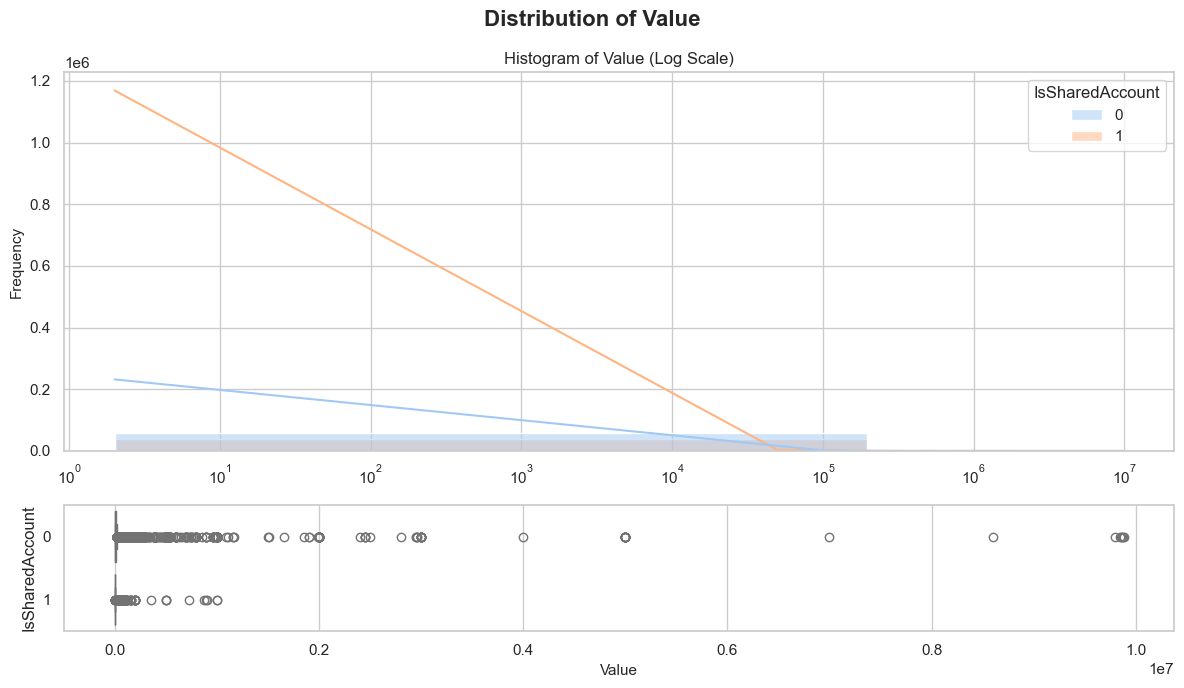

📊 Distribution of 'Amount' (Capped at 95th Percentile, Shared Split)


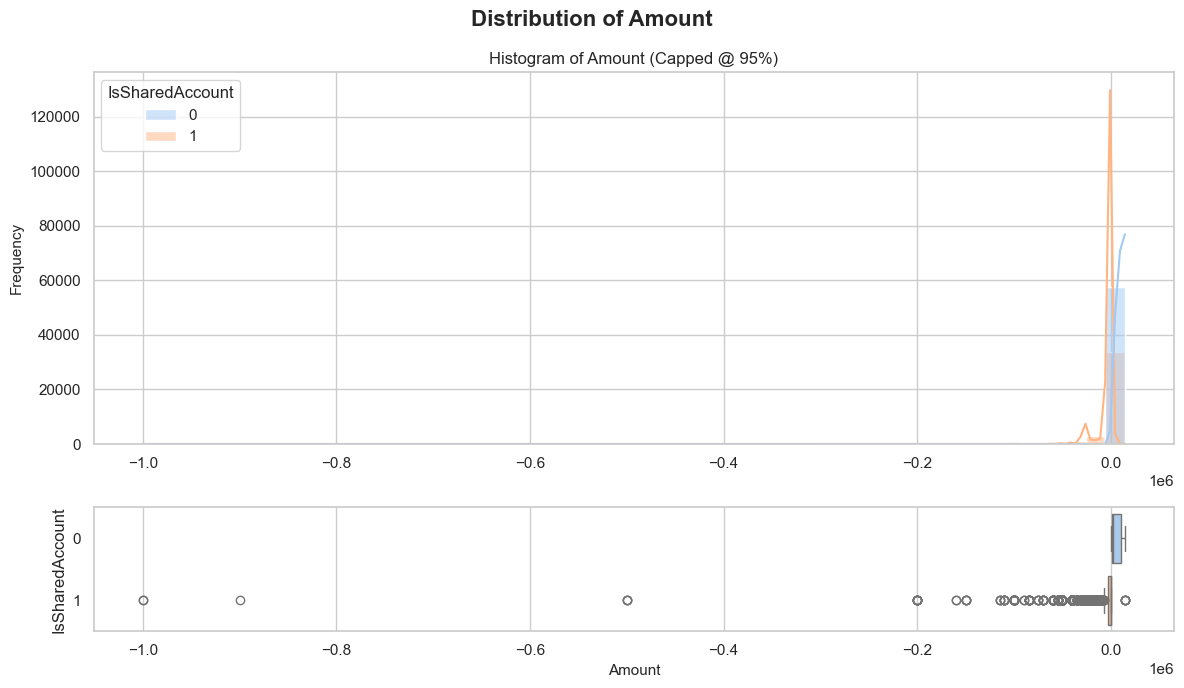

📊 Distribution of 'Value' (Capped at 95th Percentile, Shared Split)


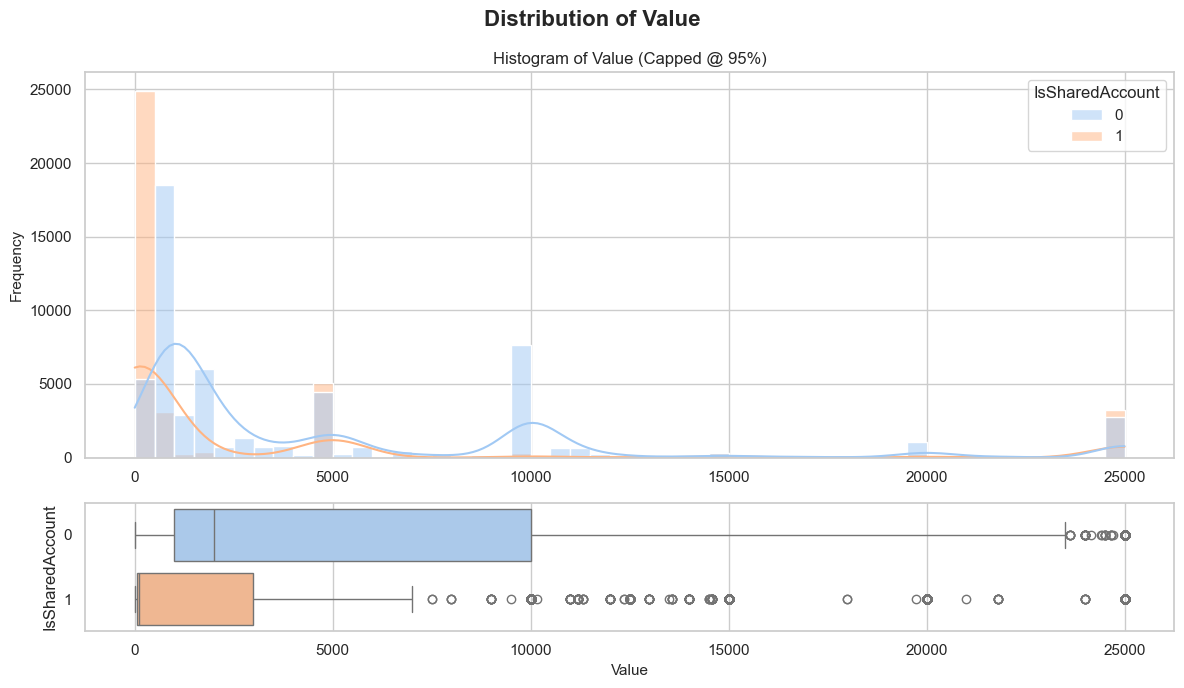

In [8]:
# ───────────────────────────────────────────────────────────────────────────────
# 💰 Layer 4 – Monetary Value Distributions (Enhanced with Shared Split & Dynamic Capping)
# ───────────────────────────────────────────────────────────────────────────────

# ✅ Import the enhanced DistributionAnalyzer with capping support
from src.eda.distribution_analyzer import DistributionAnalyzer

# ✅ Step 1: Initialize the analyzer with the enriched DataFrame (tagged with shared accounts)
dist_viz = DistributionAnalyzer(
    tagged_df
)  # Input is the shared-account–tagged DataFrame

# ✅ Step 2: Plot 'Amount' distribution (shared vs. individual accounts, log scale, no capping)
print(
    "📊 Distribution of 'Amount' (Signed Flow) by Shared Account (Log Scaled, No Capping)"
)
dist_viz.plot_numeric(
    column="Amount", log_scale=True, apply_cap=False, hue="IsSharedAccount"
)

# ✅ Step 3: Plot 'Value' distribution (shared vs. individual accounts, log scale, no capping)
print(
    "📊 Distribution of 'Value' (Magnitude) by Shared Account (Log Scaled, No Capping)"
)
dist_viz.plot_numeric(
    column="Value", log_scale=True, apply_cap=False, hue="IsSharedAccount"
)

# ✅ Step 4: Plot 'Amount' distribution (shared vs. individual, P95 capping for visual clarity)
print("📊 Distribution of 'Amount' (Capped at 95th Percentile, Shared Split)")
dist_viz.plot_numeric(
    column="Amount",
    log_scale=False,
    apply_cap=True,
    cap_percentile=0.95,
    hue="IsSharedAccount",
)

# ✅ Step 5: Plot 'Value' distribution (shared vs. individual, P95 capping for visual clarity)
print("📊 Distribution of 'Value' (Capped at 95th Percentile, Shared Split)")
dist_viz.plot_numeric(
    column="Value",
    log_scale=False,
    apply_cap=True,
    cap_percentile=0.95,
    hue="IsSharedAccount",
)

# ✅ Optional: Apply permanent capping to the dataset for modeling consistency
# capped_df = dist_viz.apply_capping_to_dataframe(column="Amount", cap_percentile=0.95)
# capped_df = dist_viz.apply_capping_to_dataframe(column="Value", cap_percentile=0.95)

## 🏢 Layer 5 – Shared Subscription Diagnostics (Corporate Account Check)

This layer performs a diagnostic analysis to identify **SubscriptionIds** that are mapped to multiple **AccountIds**, signaling potential **corporate accounts, multi-entity subscriptions, or anomalous linkage behaviors**.

Key objectives:
- ✅ Flag subscriptions that span more than one AccountId (likely shared/corporate)
- ✅ Provide a defensible tagging (`IsSharedSubscription`) for downstream modeling or segmentation
- ✅ Display top suspect subscriptions for manual review and potential exclusion or feature engineering

Understanding subscription sharing is critical for:
- 📊 Accurate aggregation for customer segmentation (avoiding over-counting)
- 🔍 Identifying special risk groups tied to corporate or pooled subscriptions
- 🛡️ Ensuring defensible proxy label creation for model training


In [9]:
# ───────────────────────────────────────────────────────────────────────────────
# 🏢 Layer 5 – Shared Subscription Diagnostics (Corporate Account Check)
# ───────────────────────────────────────────────────────────────────────────────

# ✅ Step 1: Import the SharedSubscriptionChecker class
from src.eda.shared_subscription_checker import (
    SharedSubscriptionChecker,
)  # Import diagnostic module

# ✅ Step 2: Initialize the checker with the tagged transactional DataFrame
subscription_checker = SharedSubscriptionChecker(tagged_df)  # Create instance

# ✅ Step 3: Compute subscription sharing stats (AccountId and CustomerId uniqueness + flags)
subscription_stats = (
    subscription_checker.compute_subscription_sharing()
)  # Run diagnostic

# ✅ Step 4: Display top suspect shared subscriptions (sorted by number of AccountIds)
subscription_checker.print_top_shared_subscriptions(top_n=10)  # Visual diagnostic

🔍 Top 10 Shared Subscriptions by AccountId:


,SubscriptionId,UniqueAccountIds,UniqueCustomerIds,IsSharedSubscription
3074,SubscriptionId_4674,3,3,1
2068,SubscriptionId_3489,2,1,1
2075,SubscriptionId_3495,2,2,1
2301,SubscriptionId_375,2,2,1
2366,SubscriptionId_3829,2,2623,1
3211,SubscriptionId_4836,2,31,1
1,SubscriptionId_1000,1,1,0
2,SubscriptionId_1001,1,1,0
3,SubscriptionId_1002,1,1,0
4,SubscriptionId_1004,1,1,0


## 🧮 Layer 6 – Categorical Feature Analysis (Channels, Products, Providers)

This layer explores key categorical variables to understand customer interaction patterns across channels, products, and merchant providers.

- 🛍 `ProductCategory`: What types of goods dominate?
- 🌐 `ChannelId`: Are users transacting via web, mobile, or Pay Later?
- 🏢 `ProviderId`: Which merchant platforms are most active?
- ⚙️ `PricingStrategy`, `CurrencyCode`: Ancillary features with potential signal

The goal is to surface dominant classes, understand class imbalance, and identify categories potentially linked to fraud or disengagement.


🛍 Top Product Categories


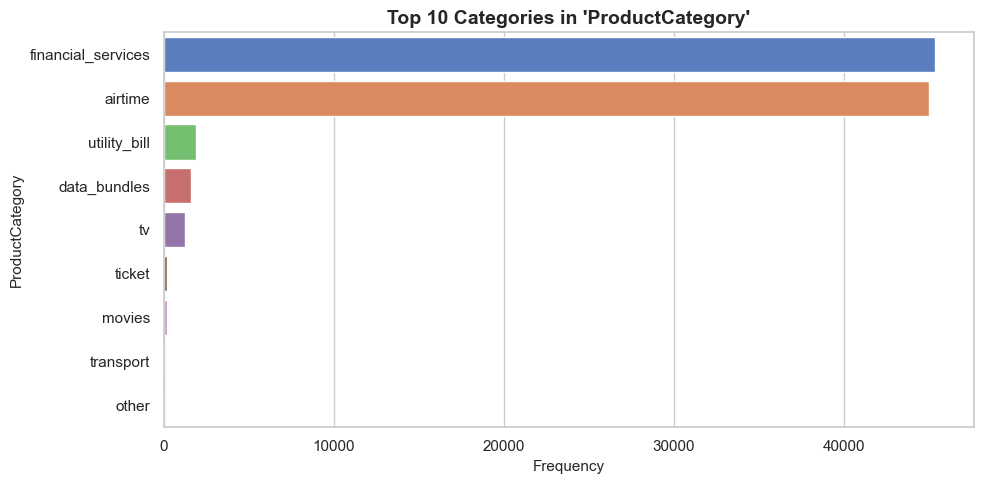

🌐 Transaction Channels (ChannelId)


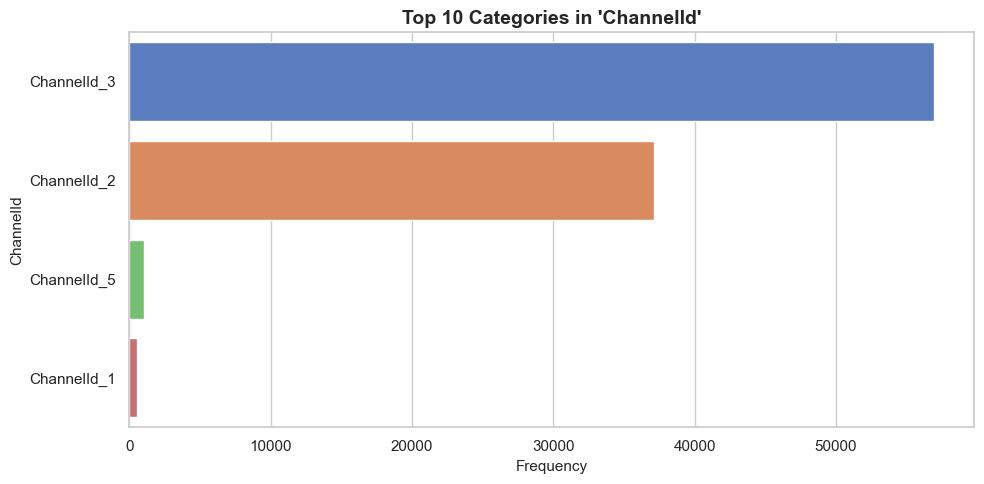

🏢 Most Active Providers


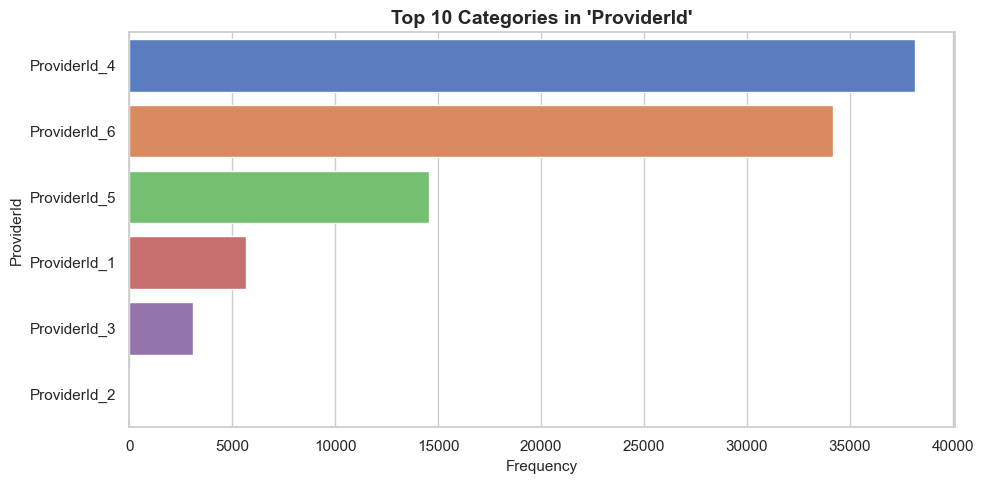

⚙️ Pricing Strategy Distribution


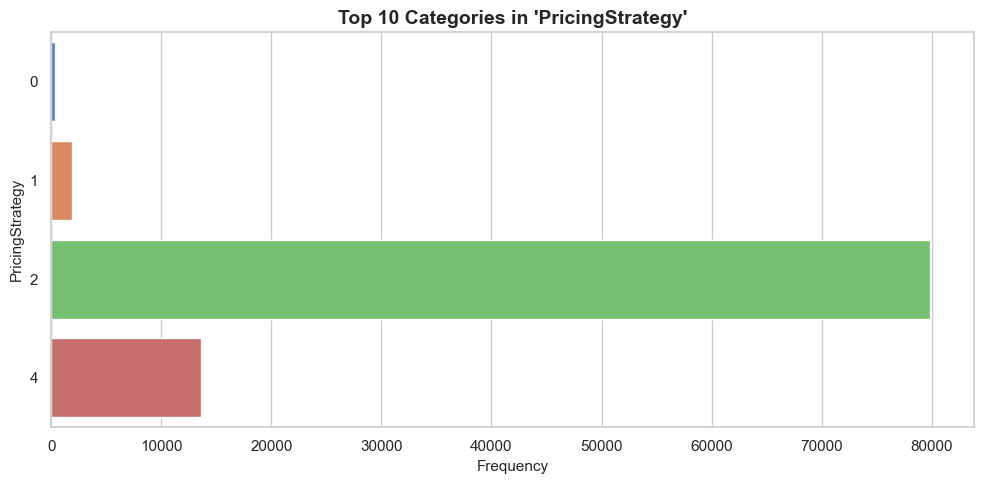

💱 Currency Codes


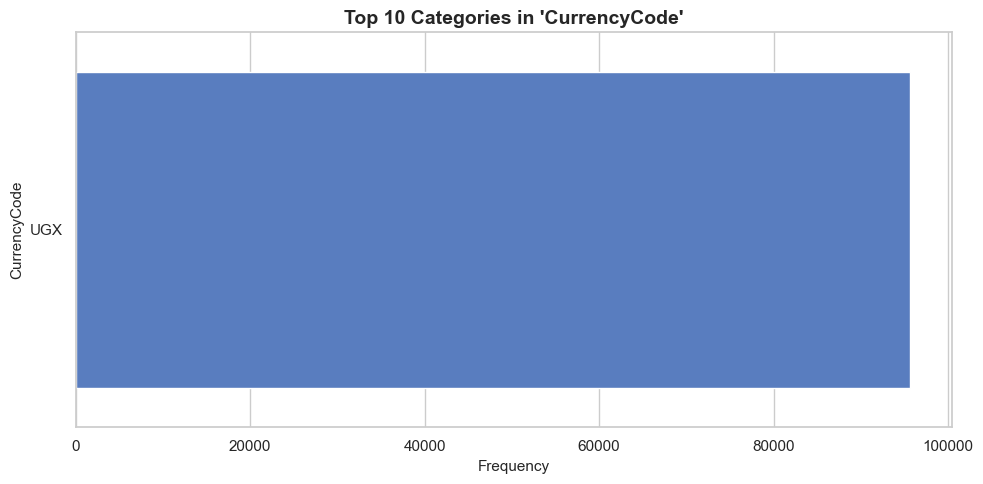

In [10]:
# ------------------------------------------------------------------------------
# 🧮 Layer 6 – Categorical Feature Distributions (Top-K Frequency)
# ------------------------------------------------------------------------------

# ✅ Reuse the distribution analyzer instance
# If reloading notebook from scratch, uncomment:
# from src.eda.distribution_analyzer import DistributionAnalyzer
# dist_viz = DistributionAnalyzer(df)

# ✅ Step 1: Visualize Product Category spread
print("🛍 Top Product Categories")
dist_viz.plot_categorical("ProductCategory", top_k=10)

# ✅ Step 2: Visualize transaction channel preference
print("🌐 Transaction Channels (ChannelId)")
dist_viz.plot_categorical("ChannelId", top_k=10)

# ✅ Step 3: Visualize dominant providers (e.g., merchants or platforms)
print("🏢 Most Active Providers")
dist_viz.plot_categorical("ProviderId", top_k=10)

# ✅ Step 4 (Optional): Pricing strategy breakdown
# 🧼 Defensive type fix – ensure PricingStrategy is treated as categorical
if "PricingStrategy" in df.columns:
    df["PricingStrategy"] = df["PricingStrategy"].astype("category")
    dist_viz.df["PricingStrategy"] = df["PricingStrategy"]  # Sync update inside class

print("⚙️ Pricing Strategy Distribution")
dist_viz.plot_categorical("PricingStrategy", top_k=10)

# ✅ Step 5 (Optional): CurrencyCode check (should likely be 1–2 max)
print("💱 Currency Codes")
dist_viz.plot_categorical("CurrencyCode", top_k=10)

## ⏰ Layer 7 – Temporal Patterns in User Activity

This layer explores the time-based structure of transactions, identifying behavioral patterns by hour, weekday, and monthly trends.

- 🧭 Converts `TransactionStartTime` to datetime
- 🕒 Visualizes transaction peaks by hour of day
- 📆 Reveals weekday vs weekend usage patterns
- 📈 Plots overall activity volume by month
- 🧠 Supports temporal segment modeling (recency, time clusters)

These insights can inform downstream proxy labels, customer segmentation, or early risk scoring based on transaction timing.


🕒 Hourly Transaction Volume


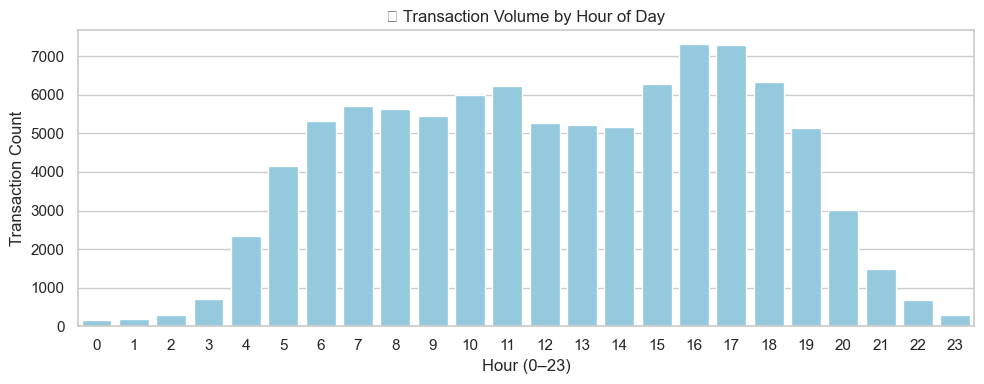

📆 Daily Transaction Volume


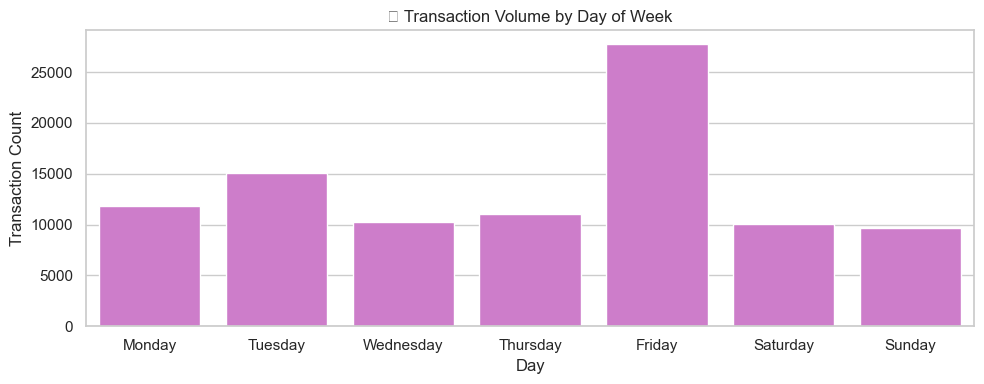

📈 Monthly Transaction Trend


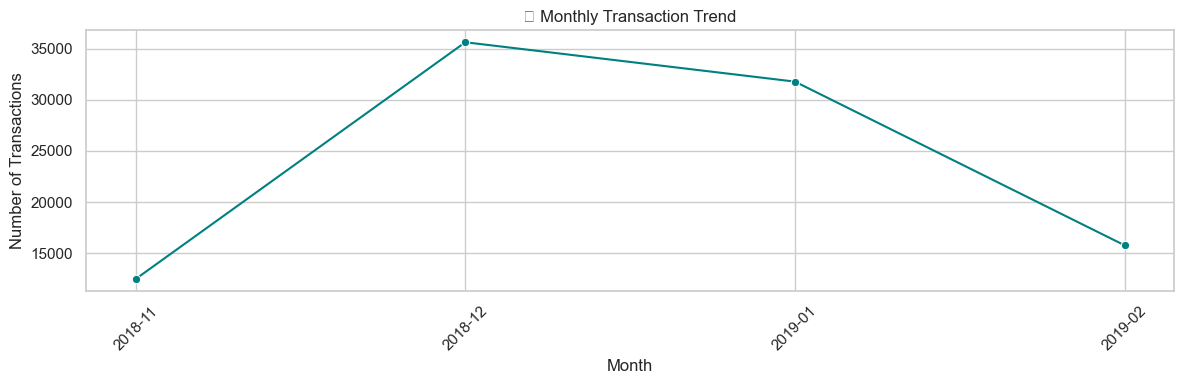

In [11]:
# ------------------------------------------------------------------------------
# ⏰ Layer 7 – Temporal Behavior Analysis (Hour, Day, Month)
# ------------------------------------------------------------------------------

# ✅ Import temporal analyzer (if not already loaded)
from src.eda.temporal_behavior_analyzer import TemporalBehaviorAnalyzer

# ✅ Initialize analyzer with timestamp column
time_analyzer = TemporalBehaviorAnalyzer(df, datetime_col="TransactionStartTime")

# ✅ Step 1: Hour-of-day pattern
print("🕒 Hourly Transaction Volume")
time_analyzer.plot_transactions_by_hour()

# ✅ Step 2: Day-of-week pattern
print("📆 Daily Transaction Volume")
time_analyzer.plot_transactions_by_dayofweek()

# ✅ Step 3: Monthly activity trend
print("📈 Monthly Transaction Trend")
time_analyzer.plot_monthly_trend()

## 💳 Layer 8 – Customer Behavioral Profiling with Shared vs. Individual RFM Segmentation

This layer computes Recency, Frequency, and Monetary (RFM) behavioral metrics for each customer in the transaction dataset.  
Key business drivers:
- ✅ Differentiate behavioral patterns of shared vs. individual account holders
- ✅ Enable defensible segmentation for downstream clustering and risk modeling
- ✅ Support feature engineering for model inputs and proxy labels

Metrics generated:
1. 📅 Recency → Days since last transaction
2. 🔁 Frequency → Number of transactions
3. 💰 Monetary → Total transaction value

Outputs:
- 🧩 Overall RFM metrics
- 🧩 Shared account RFM metrics
- 🧩 Individual account RFM metrics


In [14]:
# ───────────────────────────────────────────────────────────────────────────────
# 💳 Layer 8 – Customer Behavior Profiling via RFM with Shared Account Segmentation
# ───────────────────────────────────────────────────────────────────────────────

# ✅ Import the enhanced RFM Profiler
from src.eda.customer_behavior_analyzer import CustomerBehaviorProfiler

# ✅ Step 1: Initialize the profiler with transaction data and shared account flag
rfm_profiler = CustomerBehaviorProfiler(
    df=tagged_df,  # Use shared-account enriched DataFrame
    customer_id_col="CustomerId",  # Customer identifier
    date_col="TransactionStartTime",  # Transaction date
    value_col="Value",  # Monetary value
    shared_col="IsSharedAccount",  # Shared account flag for segmentation
)

# ✅ Step 2: Define snapshot date for Recency calculation
snapshot_date = "2019-02-14"

# ✅ Step 3: Compute RFM metrics with shared vs. individual segmentation
rfm_results = rfm_profiler.compute_rfm(
    snapshot_date=snapshot_date, split_by_shared=True
)

# ✅ Step 4: Display overall RFM metrics
print("🧩 Overall RFM Metrics")
display(rfm_results["Overall"].head())

# ✅ Step 5: Display individual (non-shared) RFM metrics
print("🧩 Individual Account RFM Metrics")
display(rfm_results.get("Individual", pd.DataFrame()).head())

# ✅ Step 6: Display shared account RFM metrics
print("🧩 Shared Account RFM Metrics")
display(rfm_results.get("Shared", pd.DataFrame()).head())

✅ RFM computed: ['Overall', 'Shared', 'Individual'] (Snapshot: 2019-02-14)
🧩 Overall RFM Metrics


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,84,1,10000
1,CustomerId_10,84,1,10000
2,CustomerId_1001,89,5,30400
3,CustomerId_1002,26,11,4775
4,CustomerId_1003,12,6,32000


🧩 Individual Account RFM Metrics


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1001,89,3,25200
1,CustomerId_1002,28,5,4500
2,CustomerId_1003,12,4,26000
3,CustomerId_1004,53,1,2000
4,CustomerId_1005,47,6,55000


🧩 Shared Account RFM Metrics


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,84,1,10000
1,CustomerId_10,84,1,10000
2,CustomerId_1001,89,2,5200
3,CustomerId_1002,26,6,275
4,CustomerId_1003,12,2,6000


In [15]:
# ───────────────────────────────────────────────────────────────────────────────
# 💾 Merge RFM Metrics onto Transaction-Level DataFrame & Save to /data/processed
# ───────────────────────────────────────────────────────────────────────────────

# ✅ Step 1: Merge RFM table onto transaction-level tagged DataFrame
tagged_with_rfm_df = tagged_df.merge(
    rfm_results["Overall"],  # Use the overall RFM table
    on="CustomerId",  # Merge on CustomerId
    how="left",  # Keep all transactions
)

# ✅ Step 2: Sanity check merged data
print(f"✅ Merged DataFrame shape: {tagged_with_rfm_df.shape}")
print(tagged_with_rfm_df[["CustomerId", "Recency", "Frequency", "Monetary"]].head())

# ✅ Step 3: Define output path
output_path = "data/processed/enriched_transactions_with_rfm.csv"

# ✅ Step 4: Save enriched DataFrame to CSV for Task 4 (proxy labels, modeling)
tagged_with_rfm_df.to_csv(output_path, index=False)

print(f"✅ Enriched transaction-level data saved to: {output_path}")

✅ Merged DataFrame shape: (95662, 20)
        CustomerId  Recency  Frequency  Monetary
0  CustomerId_4406        1        119    203847
1  CustomerId_4406        1        119    203847
2  CustomerId_4683       81          2      1000
3   CustomerId_988        5         38    286623
4   CustomerId_988        5         38    286623
✅ Enriched transaction-level data saved to: data/processed/enriched_transactions_with_rfm.csv


## 🛡 Layer 9 – Fraud Segment Analysis

This layer inspects the distribution of fraud outcomes across key categorical dimensions.

- 📌 `FraudResult` is treated as a binary flag (0 = not fraud, 1 = fraud)
- 📊 Fraud frequency and rate are computed per segment
- 🔍 Identifies high-risk channels, products, or behaviors
- 📈 Plots relative fraud rates using horizontal bar charts

Used to detect potential risk-prone segments that can inform proxy label creation in Task 4 or model features.


✅ Fraud summary computed by 'ProductCategory'


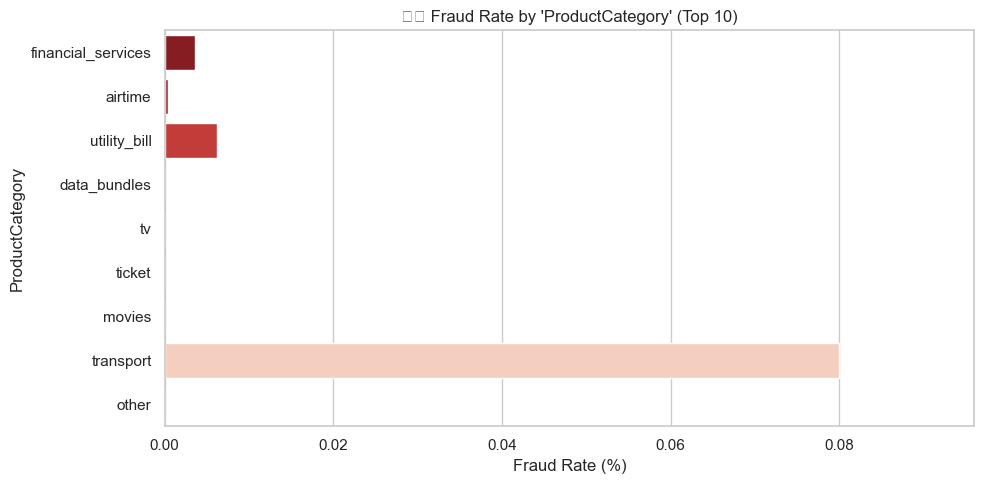

✅ Fraud summary computed by 'ChannelId'


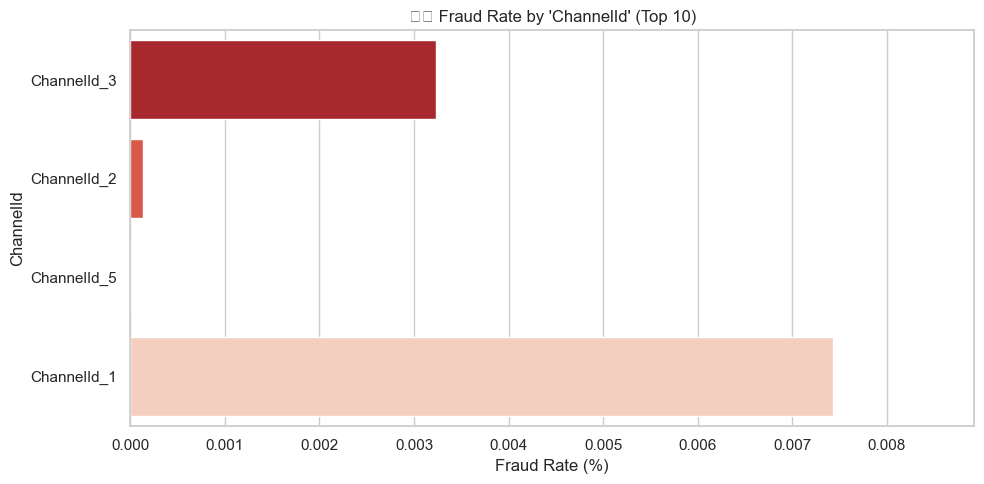

✅ Fraud summary computed by 'ProviderId'


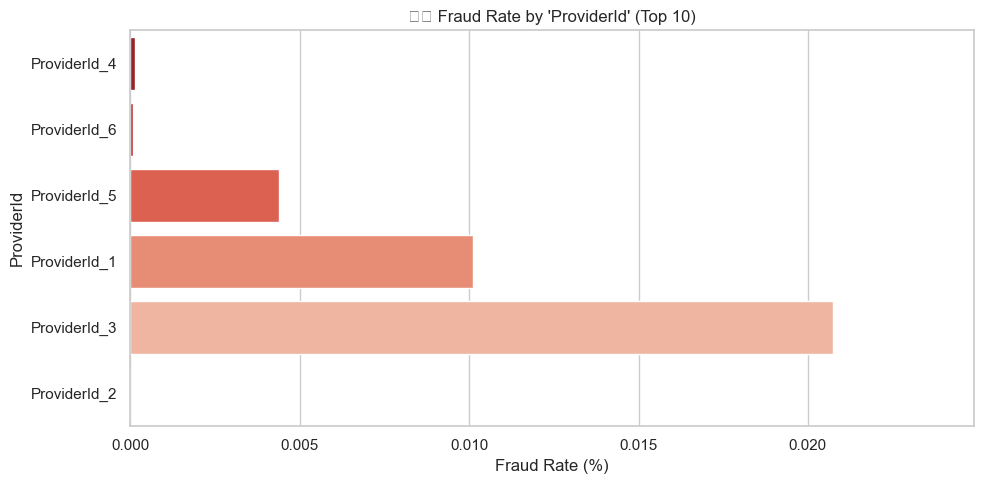

In [ ]:
# ------------------------------------------------------------------------------
# 🛡 Layer 9 – Fraud Segment Analysis
# ------------------------------------------------------------------------------

# ✅ Import the fraud segment analyzer
from src.eda.fraud_segment_analyzer import FraudSegmentAnalyzer

# ✅ Step 1: Initialize the analyzer
fraud_analyzer = FraudSegmentAnalyzer(df=df, fraud_col="FraudResult")

# ✅ Step 2: List candidate segment columns
segment_candidates = ["ProductCategory", "ChannelId", "ProviderId"]

# ✅ Step 3: Loop through each segment and plot fraud risk
for col in segment_candidates:
    try:
        fraud_analyzer.plot_fraud_rate_by_segment(segment_col=col, top_k=10)
    except Exception as e:
        print(f"⚠️ Skipped '{col}' due to error: {e}")